# Procesamiento Digital de Audio
## Caleb Rascón
### Separación de Fuentes en Línea

#### ICA

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from trianglewave import trianglewave
from delay_f import delay_f

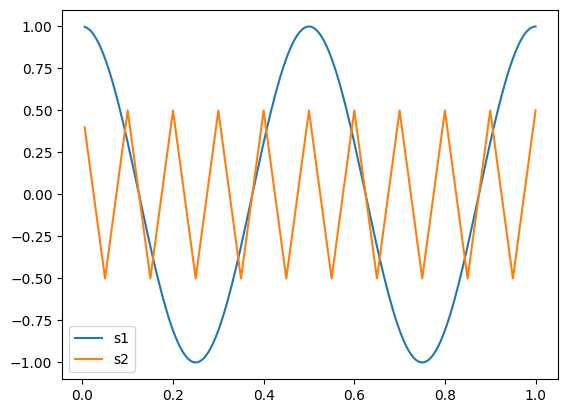

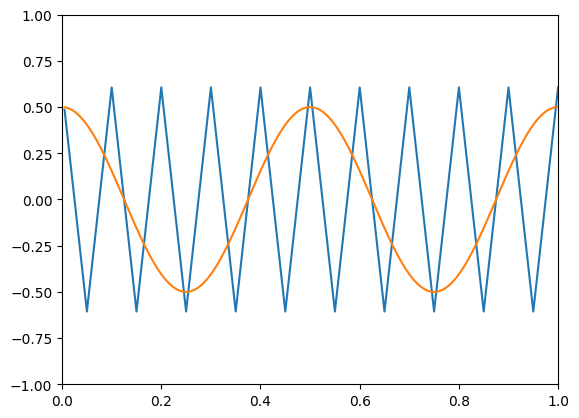

In [4]:
# Parameters
doa1 = 20 * np.pi / 180  # direction of arrival of first signal
doa2 = -40 * np.pi / 180  # direction of arrival of second signal
amp_out1 = 0.8  # pre-amplification of first signal
amp_out2 = 1.2  # pre-amplification of second signal
d = 4  # distance between microphones in meters
M = 2  # number of microphones
N = 200  # signal size in samples
do_not_delay = 1  # flag to not delay the original signals as part of the microphone model

# Simulating signals
t = np.arange(1, N + 1) / N  # time vector (1 second)
c = 343  # speed of sound
fs = N  # sampling frequency same as signal size (1 second)

# Original signals
s1 = np.cos(2 * np.pi * 2 * t)
s2 = trianglewave(10, N) * 0.5

# Microphones (input signals)
X = np.zeros((M, N))
X[0, :] = s1 + s2
for m in range(1, M):
    if do_not_delay == 1:
        X[m, :] = s1 * amp_out1 + s2 * amp_out2
    else:
        X[m, :] = delay_f(s1, (m * d / c) * np.sin(doa1), N) + delay_f(s2, (m * d / c) * np.sin(doa2), N)

plt.figure(1)
plt.plot(t, s1, label='s1')
plt.plot(t, s2, label='s2')
plt.legend()

# Centering data
X -= np.mean(X, axis=1, keepdims=True)

# Whitening data
R = X @ X.T
U, D, _ = np.linalg.svd(R, full_matrices=False)
DIM = D.shape[0]
T = np.zeros((M, M))
for i in range(DIM):
    T += 1 / np.sqrt(D[i]) * np.outer(U[:, i], U[:, i])
X = T @ X

np.random.seed(0)
w = np.random.rand(M, M)
for i in range(M):
    w[i, :] /= np.linalg.norm(w[i, :])

# Initialize loop variables
err = np.ones(M)
its = 0
maxIters = 10000
while np.max(err) > np.finfo(float).eps and its < maxIters:
    # Increment iteration counter
    its += 1

    # Save last weight matrix
    w_old = w.copy()

    # for each weight vector
    for i in range(M):
        # Last independent components
        si = w_old[i, :] @ X

        # Compute negentropy scores
        # negentropy function : f(u) = -exp(-u^2/2)
        g = si * np.exp(-0.5 * si**2)
        gp = -si**2 * np.exp(-0.5 * si**2)

        # Update weights in the direction of maximum negentropy
        w[i, :] = np.mean(X * g, axis=1) - np.mean(gp) * w_old[i, :]

        # Normalize weight vector
        w[i, :] /= np.linalg.norm(w[i, :])

    # Decorrelate weight vectors
    U, S, _ = np.linalg.svd(w, full_matrices=False)
    Sinv = np.diag(1. / S)
    w = U @ Sinv @ U.T @ w

    # Compute innovation
    for i in range(M):
        err[i] = 1 - w[i, :] @ w_old[i, :]

# ICA output
o = w @ X

plt.figure(2)
plt.plot(t, o.T * 5)
plt.axis([0, 1, -1, 1])
plt.show()